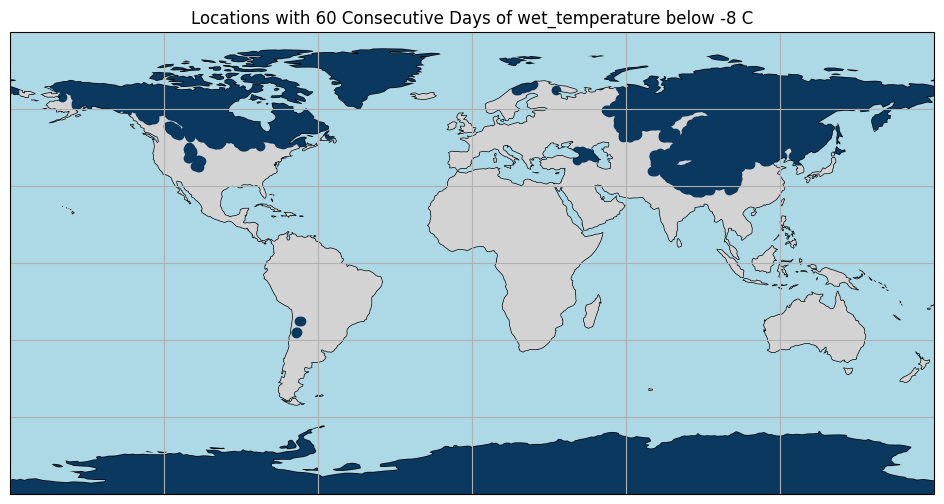

In [38]:
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

# Load the netCDF file
year = '2019'
dataset = xr.open_dataset('data/wettasmin_W5E5v2.0_'+year+'.nc')
var = 'wet_temperature'
# Define the temperature threshold
threshold = - 8

# Set the window size
window_size = 60

# Extract the necessary variables
lat = dataset['lat']
lon = dataset['lon']
temperature = dataset[var]


# Filter the dataset to the year 2001
year_dataset = dataset.sel(time=year)[var]

# Create a mask indicating if the temperature is below the threshold
mask = year_dataset < threshold

# Count the number of consecutive days below the threshold
consecutive_days = np.zeros_like(mask, dtype=int)
consecutive_days[0] = mask[0].astype(int)

for i in range(1, len(mask)):
    consecutive_days[i] = mask[i].astype(int) * (consecutive_days[i-1] + 1)

# Find the maximum consecutive days for each latitude and longitude
max_consecutive_days = np.max(consecutive_days, axis=0)

# Reshape the max_consecutive_days array based on latitude and longitude dimensions
reshaped_max_consecutive_days = max_consecutive_days.reshape(len(lat), len(lon))

# Find the latitude and longitude where the maximum consecutive days are greater than the window size
indices = np.where(reshaped_max_consecutive_days > window_size)
latitudes = lat[indices[0]]
longitudes = lon[indices[1]]

# Plot the map
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add land and ocean background
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

# Add map features
ax.coastlines()
ax.gridlines()

# Plot the selected locations
ax.scatter(longitudes, latitudes, color='#0a385f', marker='o', transform=ccrs.PlateCarree(), zorder=1)

# Add land and ocean background
ax.add_feature(cfeature.OCEAN, facecolor='lightblue',zorder=2)

# Set the plot extent to cover the entire world
ax.set_global()

# Set plot title and labels
title = 'Locations with {} Consecutive Days of {} below {} C'.format(window_size, var, threshold)
ax.set_title(title)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')


plt.savefig(
    "figs/" + title + ".png",
    bbox_inches="tight",
    dpi=300,
)
plt.show()

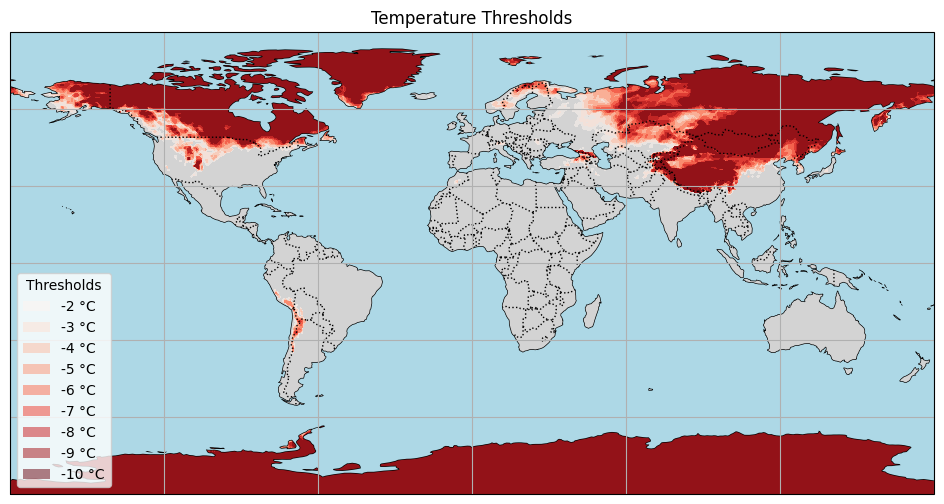

In [111]:
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

# Load the netCDF file
year = '2019'
dataset = xr.open_dataset('data/wettasmin_W5E5v2.0_'+year+'.nc')
var = 'wet_temperature'

# Set the window size
window_size = 60

# Extract the necessary variables
lat = dataset['lat']
lon = dataset['lon']
temperature = dataset[var]

# Filter the dataset to the year 2001
year_dataset = dataset.sel(time=year)[var]

# Define the threshold range
thresholds = np.arange(-2, -11, -1)

# Create a figure and subplot
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Add land and ocean background
ax.add_feature(cfeature.LAND, facecolor='lightgray')

# Iterate over each threshold and plot filled contour regions
for i in range(len(thresholds)):
    threshold = thresholds[i]
    mask = year_dataset < threshold
    
    # Apply consecutive days condition
    consecutive_days = np.zeros_like(mask, dtype=int)
    consecutive_days[0] = mask[0].astype(int)
    
    for t in range(1, len(mask)):
        consecutive_days[t] = mask[t].astype(int) * (consecutive_days[t-1] + 1)
    
    mask_consecutive = consecutive_days >= window_size
    
    mask_2d = np.any(mask_consecutive, axis=0)
    
    ax.contourf(lon, lat, mask_2d, levels=[0.5, 1], colors=[plt.cm.Reds(i / (len(thresholds) - 1)), 'none'], alpha=0.5, hatches=[None, '////'], transform=ccrs.PlateCarree())

# Add country outlines
ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='black')

# Set the plot extent to cover the entire world
ax.set_global()
ax.add_feature(cfeature.OCEAN, facecolor='lightblue', zorder=2)

# Set plot title and labels
ax.set_title('Temperature Thresholds')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Add map features
ax.coastlines()
ax.gridlines()

# Create a custom legend
threshold_labels = [str(threshold) + ' °C' for threshold in thresholds]
legend_handles = [plt.Rectangle((0, 0), 1, 1, fc=plt.cm.Reds(i / (len(thresholds) - 1)), alpha=0.5) for i in range(len(thresholds))]

ax.legend(legend_handles, threshold_labels, title='Thresholds', loc='lower left')

# Save the figure
plt.savefig("figs/temperature_thresholds.png", bbox_inches="tight", dpi=300)

# Show the plot
plt.show()


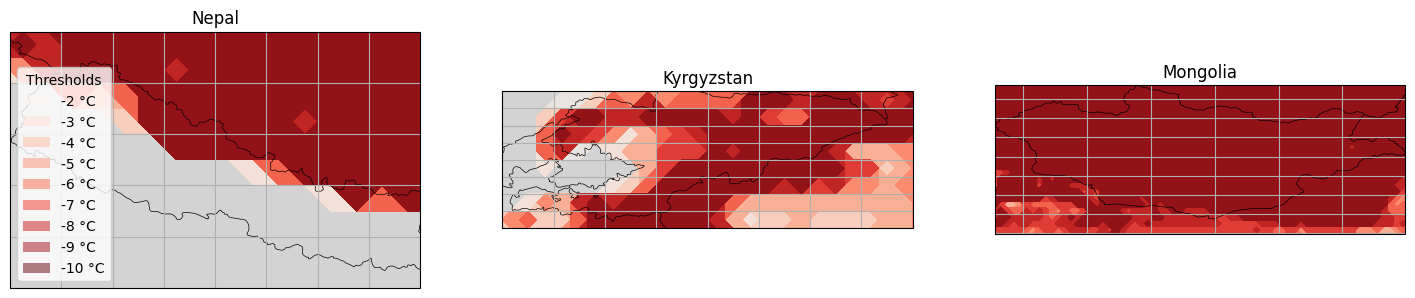

In [121]:
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

# Load the netCDF file
year = '2019'
dataset = xr.open_dataset('data/wettasmin_W5E5v2.0_'+year+'.nc')
var = 'wet_temperature'

# Set the window size
window_size = 60

# Extract the necessary variables
lat = dataset['lat']
lon = dataset['lon']
temperature = dataset[var]

# Filter the dataset to the year 2001
year_dataset = dataset.sel(time=year)[var]

# Define the threshold range
thresholds = np.arange(-2, -11, -1)

# Create a figure and subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Add land and ocean background to all subplots
for ax in axs:
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

# Define the extent for each subplot
extents = [
    #(-130, -65, 24, 50),  # USA
    #(-10, 40, 35, 70),    # Europe
    #(60, 100, 5, 40)      # India
    (80.00, 88.00, 26.00, 31.00), # Nepal
    #(88.75, 92.00, 26.70, 28.50), # Bhutan
    #(46.50, 87.35, 40.85, 55.70), # Kazakhstan
    (69, 81, 39, 43), # kyrgyzstan_extent
    #(50, 85, 35, 55), # Central Asia
    (87.75, 119.90, 40.40, 52.10), # Mongolia
    
]

# Iterate over each subplot
for i, ax in enumerate(axs):
    # Set the plot extent
    ax.set_extent(extents[i], crs=ccrs.PlateCarree())
    
    # Add country boundaries
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    
    # Iterate over each threshold and plot filled contour regions
    for j in range(len(thresholds)):
        threshold = thresholds[j]
        mask = year_dataset < threshold
        
        # Apply consecutive days condition
        consecutive_days = np.zeros_like(mask, dtype=int)
        consecutive_days[0] = mask[0].astype(int)
        
        for t in range(1, len(mask)):
            consecutive_days[t] = mask[t].astype(int) * (consecutive_days[t-1] + 1)
        
        mask_consecutive = consecutive_days >= window_size
        
        mask_2d = np.any(mask_consecutive, axis=0)
        
        ax.contourf(lon, lat, mask_2d, levels=[0.5, 1], colors=[plt.cm.Reds(j / (len(thresholds) - 1)), 'none'], alpha=0.5, hatches=[None, '////'], transform=ccrs.PlateCarree())
    
    # Add map features to the subplot
    ax.coastlines()
    ax.gridlines()

    # Set subplot title
    if i == 0:
        ax.set_title('Nepal')
    elif i == 1:
        ax.set_title('Kyrgyzstan')
    elif i == 2:
        ax.set_title('Mongolia')

# Create a custom legend
threshold_labels = [str(threshold) + ' °C' for threshold in thresholds]
legend_handles = [plt.Rectangle((0, 0), 1, 1, fc=plt.cm.Reds(j / (len(thresholds) - 1)), alpha=0.5) for j in range(len(thresholds))]

axs[0].legend(legend_handles, threshold_labels, title='Thresholds', loc='lower left')

# Save the figure
plt.savefig("figs/temperature_thresholds_subplots.png", bbox_inches="tight", dpi=300)

# Show the plot
plt.show()


In [4]:
import xarray as xr
import numpy as np
import pandas as pd

# Define the wet bulb temperature calculation function
def calculate_Tw(T, RH):
    term1 = T * np.arctan(0.151977 * np.sqrt(RH + 8.313659))
    term2 = np.arctan(T + RH)
    term3 = np.arctan(RH - 1.676331)
    term4 = 0.00391838 * np.power(RH, 1.5) * np.arctan(0.023101 * RH)

    Tw = term1 + term2 - term3 + term4 - 4.686035
    return Tw

calculate_Tw(-2,43.664787) # Should be 13.7 
    

-5.455420815149306

In [23]:
df = pd.read_csv('data/guttannen22_aws.csv')

# Extract the temperature and humidity data variables for the year 2001
temperature = df['temp']
humidity = df['RH']


# Apply the wet bulb temperature calculation to the temperature and humidity data variables
df['wet_temperature'] = calculate_Tw(temperature, humidity)
df["time"] = pd.to_datetime(df["time"], format="%Y-%m-%d %H:%M:%S")
df = df.set_index('time')
df.RH.mean()

83.63878780828293

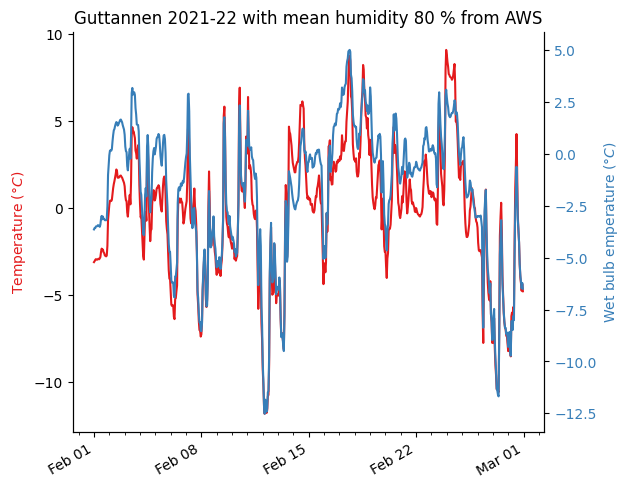

In [24]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
mypal = sns.color_palette("Set1", 2)

# Create a new DataFrame with datetime values only in February
df = df[df.index.month == 2]

fig, ax1 = plt.subplots()
y1 = df.temp
y2 = df.wet_temperature
ax1.plot(
    y1,
    color=mypal[0],
)
#ax1.set_ylim(-15, 15)
ax1.set_ylabel("Temperature ($\\degree C$)", color = mypal[0])

ax2 = ax1.twinx() 
ax2.set_ylabel('Wet bulb emperature ($\\degree C$)', color = mypal[1]) 
ax2.plot(y2, color = mypal[1]) 
ax2.tick_params(axis ='y', labelcolor = mypal[1]) 
#ax2.set_ylim(-15, 15)

ax1.spines["top"].set_visible(False)
ax2.spines["top"].set_visible(False)

ax1.xaxis.set_major_locator(mdates.WeekdayLocator())
ax1.xaxis.set_minor_locator(mdates.DayLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
fig.autofmt_xdate()
plt.xticks(rotation=45)
plt.tight_layout()
plt.title("Guttannen 2021-22 with mean humidity {:.0f} % from AWS".format(df.RH.mean()))
plt.savefig(
    "figs/Guttannen 2021-22 from AWS.png",
    bbox_inches="tight",
    dpi=300,
)

In [7]:
df2 = pd.read_csv('data/gangles21_aws.csv')

# Extract the temperature and humidity data variables for the year 2001
temperature = df2['temp']
humidity = df2['RH']


# Apply the wet bulb temperature calculation to the temperature and humidity data variables
df2['wet_temperature'] = calculate_Tw(temperature, humidity)
df2["time"] = pd.to_datetime(df2["time"], format="%Y-%m-%d %H:%M:%S")
df2 = df2.set_index('time')

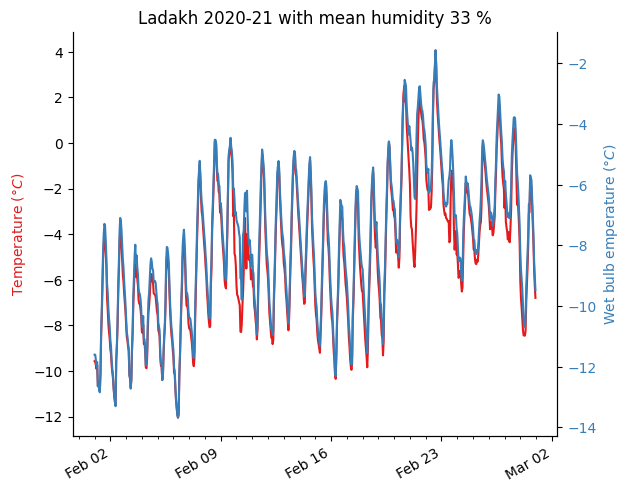

In [8]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
mypal = sns.color_palette("Set1", 2)

# Create a new DataFrame with datetime values only in February
df2 = df2[df2.index.month == 2]

fig, ax1 = plt.subplots()
y1 = df2.temp
y2 = df2.wet_temperature
ax1.plot(
    y1,
    color=mypal[0],
)
#ax1.set_ylim(-15, 15)
ax1.set_ylabel("Temperature ($\\degree C$)", color = mypal[0])

ax2 = ax1.twinx() 
ax2.set_ylabel('Wet bulb emperature ($\\degree C$)', color = mypal[1]) 
ax2.plot(y2, color = mypal[1]) 
ax2.tick_params(axis ='y', labelcolor = mypal[1]) 
#ax2.set_ylim(-15, 15)

ax1.spines["top"].set_visible(False)
ax2.spines["top"].set_visible(False)

ax1.xaxis.set_major_locator(mdates.WeekdayLocator())
ax1.xaxis.set_minor_locator(mdates.DayLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
fig.autofmt_xdate()
plt.xticks(rotation=45)
plt.tight_layout()
plt.title("Ladakh 2020-21 with mean humidity {:.0f} %".format(df2.RH.mean()))
plt.savefig(
    "figs/Ladakh 2020-21 from AWS.png",
    bbox_inches="tight",
    dpi=300,
)


In [34]:
#loc = 'Gangles 2020-21'
loc = 'Guttannen 2021-22'
if loc == 'Guttannen 2021-22':
    target_lat, target_lon=46.65549,8.29149 #Guttannen

if loc == 'Gangles 2020-21':
    target_lat, target_lon=34.216638,77.606949 #Gangles


# Load the netCDF file
year = '2019'
ds_temp = xr.open_dataset('data/tasmin_W5E5v2.0_20110101-20191231.nc')
ds_rh = xr.open_dataset('data/hurs_W5E5v2.0_20110101-20191231.nc')
ds_wettemp = xr.open_dataset('data/wettasmin_W5E5v2.0_'+year+'.nc')
var = 'wet_temperature'


# Select the data at the specified coordinates
ds_temp=ds_temp.sel(time=year)
ds_rh=ds_rh.sel(time=year)
ds_temp = ds_temp.sel(lat=target_lat, lon=target_lon, method='nearest')
ds_rh = ds_rh.sel(lat=target_lat, lon=target_lon, method='nearest')
ds_wettemp = ds_wettemp.sel(lat=target_lat, lon=target_lon, method='nearest')

# Extract temperature values for the month of February
temp_feb = ds_temp.sel(time=ds_temp['time.month'] == 2)['tasmin']
rh_feb = ds_rh.sel(time=ds_rh['time.month'] == 2)['hurs']
wettemp_feb = ds_wettemp.sel(time=ds_wettemp['time.month'] == 2)['wet_temperature']

# Convert xarray Dataset to pandas DataFrame
df1 = temp_feb.to_dataframe()
df2 = wettemp_feb.to_dataframe()
df3 = rh_feb.to_dataframe()
df1['temp']=df1['tasmin']-273.15
df2['wet_temp']=df2['wet_temperature']
df3['RH']=df3['hurs']

# Convert the index to a datetime index
df1.index = pd.to_datetime(df1.index)
df2.index = pd.to_datetime(df2.index)
df3.index = pd.to_datetime(df3.index)
df = pd.concat([df1, df2,df3], axis=1)
df.head()

,lon,lat,tasmin,temp,lon,lat,wet_temperature,wet_temp,lon,lat,hurs,RH
time,,,,,,,,,,,,
2019-02-01,8.25,46.75,269.349091,-3.800903,8.25,46.75,-5.148529,-5.148529,8.25,46.75,82.785881,82.785881
2019-02-02,8.25,46.75,271.318451,-1.831543,8.25,46.75,-2.792829,-2.792829,8.25,46.75,89.197914,89.197914
2019-02-03,8.25,46.75,268.656097,-4.493896,8.25,46.75,-5.403747,-5.403747,8.25,46.75,89.297722,89.297722
2019-02-04,8.25,46.75,264.927979,-8.222015,8.25,46.75,-9.907665,-9.907665,8.25,46.75,72.554703,72.554703
2019-02-05,8.25,46.75,265.595520,-7.554474,8.25,46.75,-9.932425,-9.932425,8.25,46.75,53.176453,53.176453


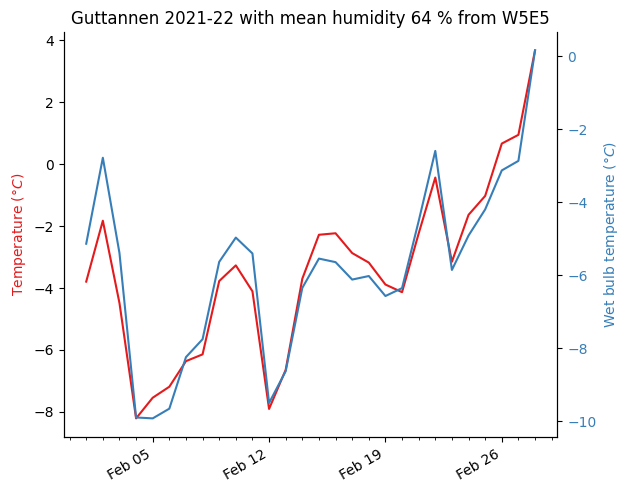

In [35]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
mypal = sns.color_palette("Set1", 2)

fig, ax1 = plt.subplots()
y1 = df.temp
y2 = df.wet_temp
ax1.plot(
    y1,
    color=mypal[0],
)
#ax1.set_ylim(-15, 15)
ax1.set_ylabel("Temperature ($\\degree C$)", color = mypal[0])

ax2 = ax1.twinx() 
ax2.set_ylabel('Wet bulb temperature ($\\degree C$)', color = mypal[1]) 
ax2.plot(y2, color = mypal[1]) 
ax2.tick_params(axis ='y', labelcolor = mypal[1]) 
#ax2.set_ylim(-15, 15)

ax1.spines["top"].set_visible(False)
ax2.spines["top"].set_visible(False)

ax1.xaxis.set_major_locator(mdates.WeekdayLocator())
ax1.xaxis.set_minor_locator(mdates.DayLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
fig.autofmt_xdate()
plt.xticks(rotation=45)
plt.tight_layout()
title = "{} with mean humidity {:.0f} % from W5E5".format(loc, df.RH.mean())
plt.title(title)
plt.savefig(
    "figs/" + title + ".png",
    bbox_inches="tight",
    dpi=300,
)